### Monte Carlo - Deep Reinforcement Learning

### In this notebook, I am using Open AI's gym environment of Black jack game.
### I will be implementing Monte Carlo methods for both Prediction and Control.


In [2]:
import sys

import gym

import numpy as np

from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

### Staring the environment of Black jack game from the gym.

In [3]:
env = gym.make('Blackjack-v0')

C:\Users\Syed Zain Raza\Anaconda3\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Printing the states of the games.
### In gym, a state of Black jack game has total three scenarios which are:
 - Sum of the player cards - 0 to 31
 - Card which dealer is showing - 1 to 10
 - Whether player has an ace or not - yes or no
 
### There are two action states which are:
 - Stick - 0
 - Hit - 1
 
 
### The following code verifies it by printing the values
 

In [4]:
print(env.observation_space)

print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


### Following code plays the game using a random policy

In [5]:
for i_episode in range(3):
    
    state = env.reset()
    
    while True:
        
        print(state)
        
        action = env.action_space.sample()
        
        state, reward, done, info = env.step(action)
        
        if done:
            
            print('End game! Reward: ', reward)
            
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            
            break

(6, 10, False)
End game! Reward:  1.0
You won :)

(10, 9, False)
(15, 9, False)
End game! Reward:  -1
You lost :(

(5, 10, False)
End game! Reward:  -1.0
You lost :(



### Prediction

### This part explains the estimation of the action value function.

### Monte Carlo method learns directly from the episode of the experience.

### This function is for generating an episode by following a policy.

### Policy used in this function has two parts as follows:
 - If a player's cards sum is greater than 20 then he/she will stick with a probability of 80 percent and hit with a probability of 20 percent.
 - If a player's cards sum is less than 20 then he/she will hit with a probability of 80 percent and stick with a probability of 20 percent.

In [6]:
def generate_episode_from_limit_stochastic(bj_env):
    
    episode = []
    
    state = bj_env.reset()
    
    while True:
        
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        
        action = np.random.choice(np.arange(2), p=probs)
        
        next_state, reward, done, info = bj_env.step(action)
        
        episode.append((state, action, reward))
        
        state = next_state
        
        if done:
            break
    
    return episode

### Lets generate episodes using the above defined function

In [7]:
for i in range(3):
    
    print(generate_episode_from_limit_stochastic(env))

[((14, 6, False), 1, 0), ((18, 6, False), 1, -1)]
[((18, 4, False), 1, 0), ((19, 4, False), 1, -1)]
[((15, 6, False), 1, -1)]


### The following function is the main function for prediction.

### It gets four things as input:
 - Environment
 - How many episodes it has to run
 - Function for generating the episodes
 - Gamma, it is a discount rate whose value can be between 0 and 1.
 
### The function loops over the all the episodes and estimates the action value function by dividing with total number of visits and action values.

In [8]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(1, num_episodes+1):
        
        if i_episode % 1000 == 0:
            
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            
            sys.stdout.flush()
       
        
        episode = generate_episode(env)
      
        states, actions, rewards = zip(*episode)
       
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
      
        for i, state in enumerate(states):
            
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            
            N[state][actions[i]] += 1.0
            
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    
    return Q

### The following code obtains the action value function.

### Then gets a specific state value function and plots it for visualizaiton.

Episode 500000/500000.

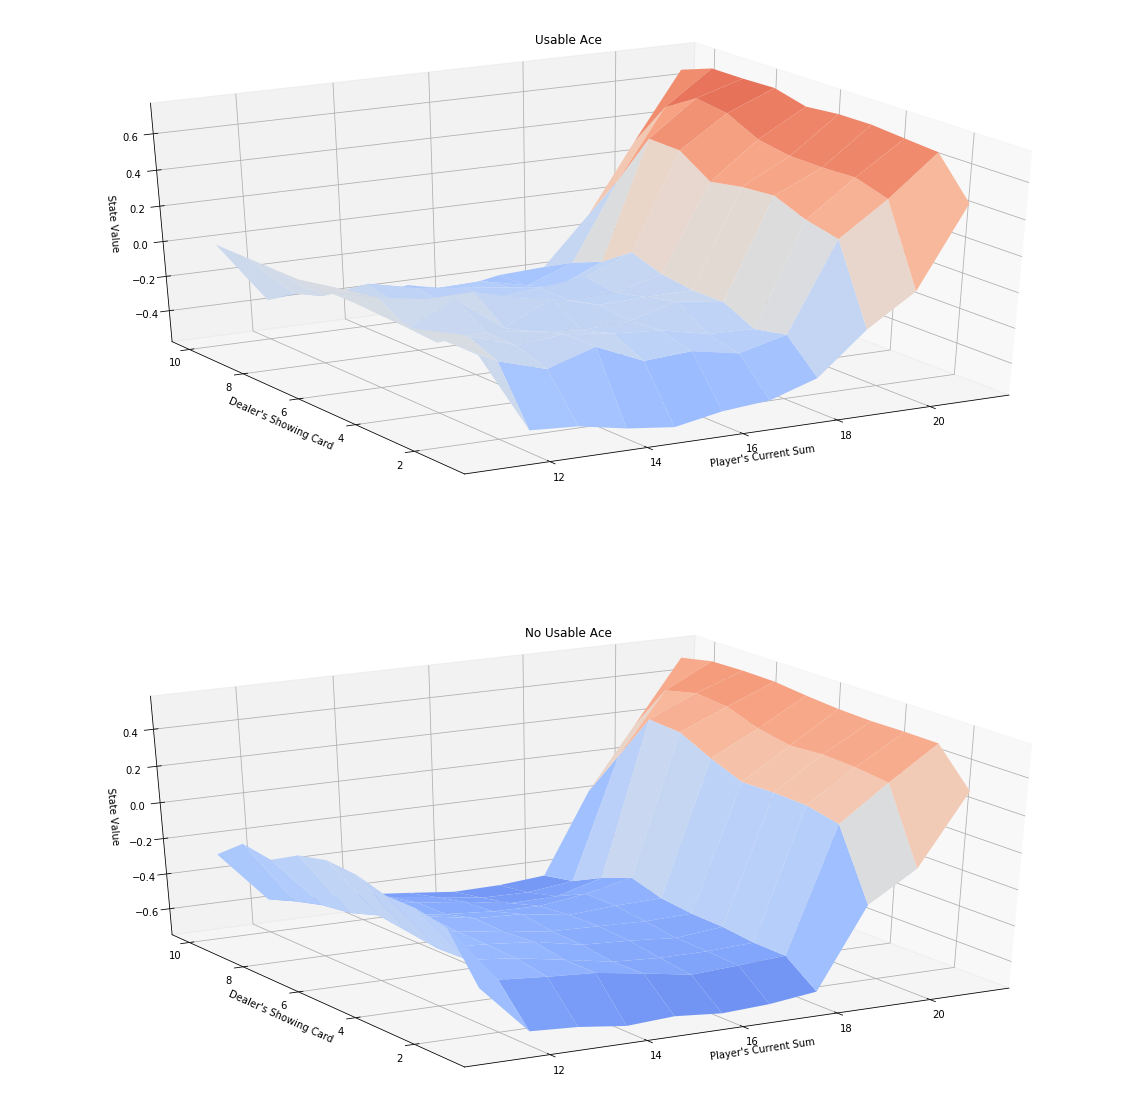

In [9]:
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

plot_blackjack_values(V_to_plot)

### Control

### In this part, I will write MC control for optimizing the value function.

### In the following cell, there are three functions which are as follows:
 - First one is for generating an episode from current Q given environment, epsilon and number of actions.
 - Second one is for getting probabilities of in accordance with the epsilon greedy policy.
 - Third function is for updating the action value function with most recent episode.

In [10]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    
    episode = []
    
    state = env.reset()
    
    while True:
        
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        
        next_state, reward, done, info = env.step(action)
        
        episode.append((state, action, reward))
        
        state = next_state
        
        if done:
            break
    
    return episode

def get_probs(Q_s, epsilon, nA):
    
    
    policy_s = np.ones(nA) * epsilon / nA
    
    best_a = np.argmax(Q_s)
    
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    
    states, actions, rewards = zip(*episode)
    
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    for i, state in enumerate(states):
        
        old_Q = Q[state][actions[i]] 
        
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    
    return Q

### The following code is for initializing the epsilon, generating episode and finally updating the Q.
### We finally get a policy from the final action value function estimate.

In [11]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    
    nA = env.action_space.n
   
    Q = defaultdict(lambda: np.zeros(nA))
    
    epsilon = eps_start
    
    for i_episode in range(1, num_episodes+1):
        
        if i_episode % 1000 == 0:
            
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            
            sys.stdout.flush()
      
        epsilon = max(epsilon*eps_decay, eps_min)
        
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        
        Q = update_Q(env, episode, Q, alpha, gamma)
   
    
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    
    return policy, Q

### Obtain the estimated policy and action value function.

In [12]:
policy, Q = mc_control(env, 500000, 0.02)

Episode 500000/500000.

### Print the the plot for the state value function

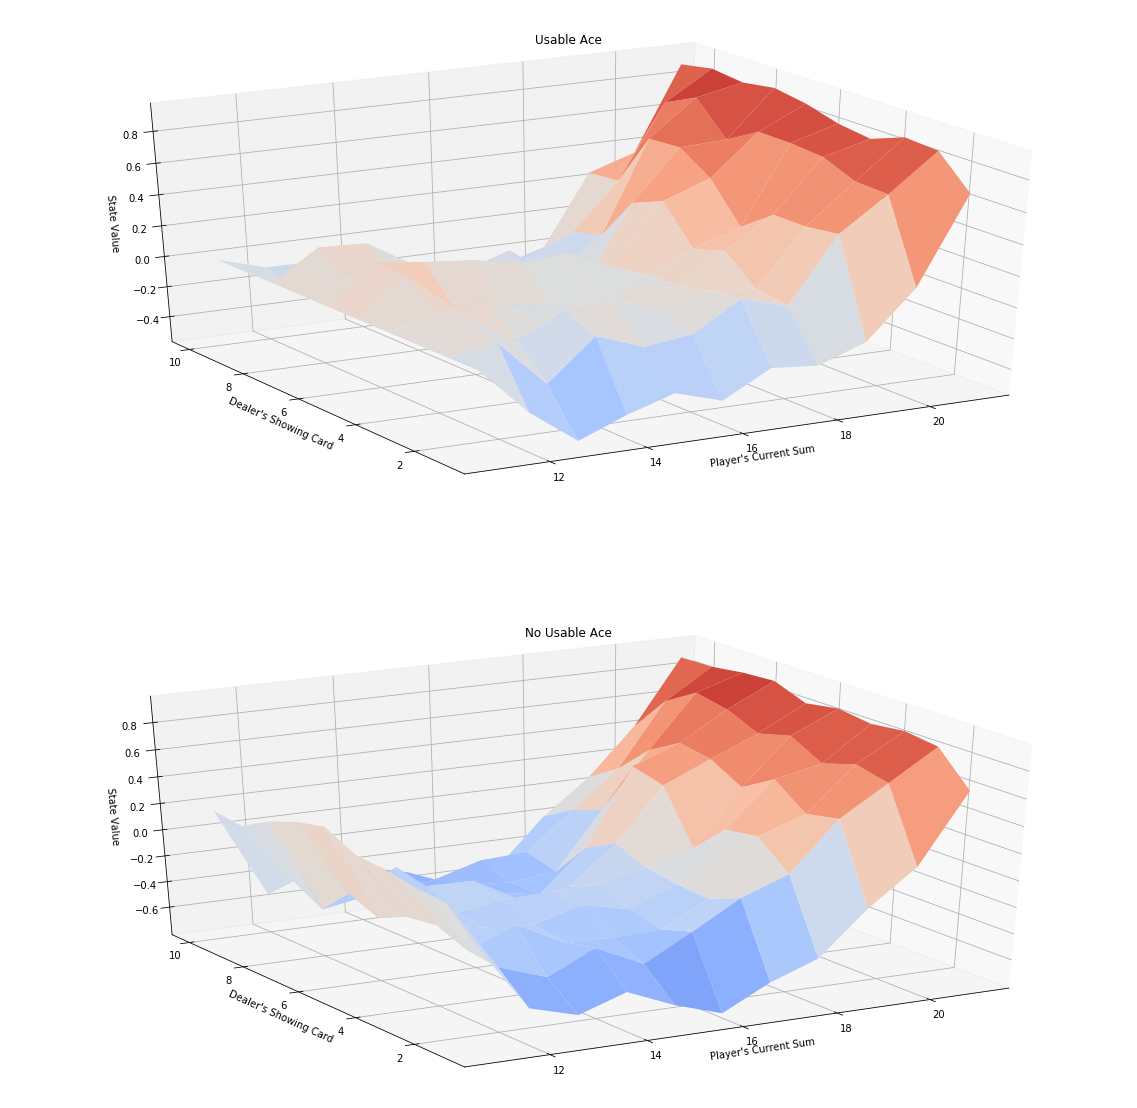

In [13]:
V = dict((k,np.max(v)) for k, v in Q.items())

plot_blackjack_values(V)

### Plot the estimated policy

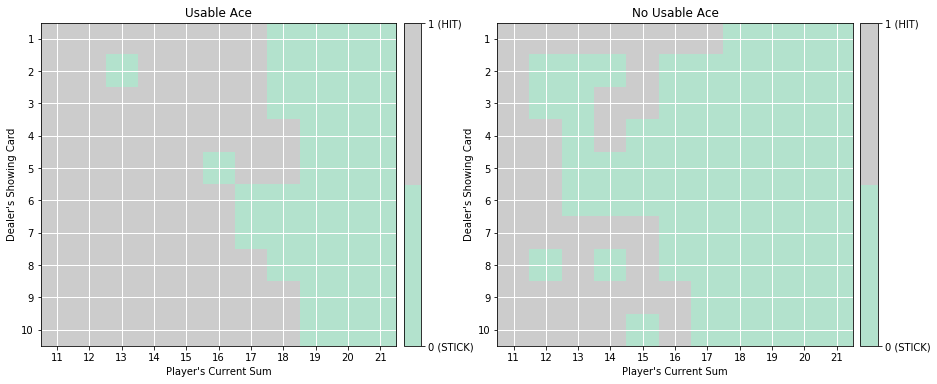

In [14]:
plot_policy(policy)